In [1]:
%load_ext autoreload

%autoreload 2

device = 'cuda'

In [2]:
import torch

In [3]:
from pianogen.dataset.pianorolldataset import PianoRollDataset
from pianogen.dataset.tokenized import TokenizedPianoRollDataset
from pianogen.tokenizer import PianoRollTokenizer
from torch.utils.data import DataLoader

pr_ds = PianoRollDataset(r'W:\music\music-data-analysis\data', max_duration=32*150, segment_len=32, hop_len=32) # 1 bar
tokenizer = PianoRollTokenizer(n_pitch=88, n_velocity=32, token_seq_len=120+1)
ds = TokenizedPianoRollDataset(pr_ds, tokenizer)
dl = DataLoader(ds,batch_size=32, shuffle=True, num_workers=8)

Loaded 253780 samples from 2570 songs


ok so we need a vae, where

the encoder is sequence in, embedding out

the latent is the embedding

the decoder is the embedding in, sequence out

In [4]:
import torch.nn as nn

from pianogen.model.model import BinaryPositionalEncoding, SinusoidalPositionalEncoding

class PositionalEncoding(nn.Module):
    def __init__(self, binary_pe_dim, sinusoidal_pe_dim, max_len):
        super().__init__()
        self.binary_pos_encoding = BinaryPositionalEncoding(binary_pe_dim, max_len)
        self.sinusoidal_pos_encoding = SinusoidalPositionalEncoding(sinusoidal_pe_dim, max_len)

    def forward(self, x):
        return torch.cat([self.binary_pos_encoding(x), self.sinusoidal_pos_encoding(x)*0], dim=-1)

class Encoder(nn.Module):
    '''
    eats a sequence of tokens, and outputs an embedding at the emb token
    no masking
    '''
    def __init__(self, vocab_dim:int, latent_dim:int, feature_dim:int, max_len:int, n_heads:int=8, n_layers:int=6, ff_dim:int=1024):
        super().__init__()
        self.emb_token_idx = vocab_dim # the last token is the embedding token
        self.pe = PositionalEncoding(5, feature_dim//2-5, max_len)
        self.emb = nn.Embedding(vocab_dim+1, feature_dim)
        self.transformer = nn.TransformerEncoder(nn.TransformerEncoderLayer(feature_dim, n_heads, ff_dim, batch_first=True), n_layers)
        self.output_layer = nn.Linear(feature_dim, latent_dim*2)

    def forward(self, x: torch.Tensor, pos: torch.Tensor):
        #x: B, L
        # add emb token
        x = torch.cat([x, torch.zeros(x.shape[0], 1, device=x.device, dtype=torch.long)+self.emb_token_idx], dim=1)
        # x: B, L+1

        # embed
        x = self.emb(x)

        # add positional encoding
        pe = self.pe(pos)
        pe = torch.cat([pe, torch.zeros_like(pe[:,0:1,:])], dim=1) # B, L+1, D
        x[:,:,:pe.shape[2]] += pe

        x = self.transformer(x)
        x = x[:,-1] # get the embedding
        x = self.output_layer(x)
        mean, logvar = x.chunk(2, dim=1)
        logvar = logvar - 6 # make var start small for faster learning
        return mean, logvar

class Decoder(nn.Module):
    '''
    eats an embedding, and outputs a sequence of tokens autoregressively
    '''
    def __init__(self, vocab_dim:int, latent_dim:int, feature_dim:int, max_len:int, n_heads:int=8, n_layers:int=6, ff_dim:int=1024):
        super().__init__()
        self.emb = nn.Embedding(vocab_dim, feature_dim)
        self.pe = PositionalEncoding(5, feature_dim//2-5, max_len)
        self.input_layer = nn.Linear(feature_dim+latent_dim, feature_dim)
        self.transformer = nn.TransformerEncoder(nn.TransformerEncoderLayer(feature_dim, n_heads, ff_dim, batch_first=True), n_layers)
        self.output_layer = nn.Linear(feature_dim, vocab_dim)

    def forward(self, latent: torch.Tensor, seq: torch.Tensor, pos: torch.Tensor):
        #latent: B, D_latent
        #seq: B, L
        x = self.emb(seq)

        # add positional encoding
        pe = self.pe(pos)
        pe = torch.cat([
            pe[:, :-1], # pe of the input tokens
            pe[:, 1:]   # pe of the target tokens
        ], dim=2) # B, L, D
        x = x + pe

        # incorporate latent
        latent = latent.unsqueeze(1) # B, 1, D
        latent = latent.expand(-1, x.shape[1], -1) # B, L, D
        x = torch.cat([x, latent], dim=2)
        x = self.input_layer(x)

        # have to be causal
        x = self.transformer.forward(x, mask=nn.Transformer.generate_square_subsequent_mask(x.shape[1]).to(x.device), is_causal=True)
        x = self.output_layer(x)
        return x


class VAE(nn.Module):
    def __init__(self, encoder: Encoder, decoder: Decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, seq: torch.Tensor, pos: torch.Tensor, return_latent: bool=False):
        latent_mean, latent_logvar = self.encoder(seq[:,1:], pos[:,1:])
        latent = self.reparameterize(latent_mean, latent_logvar)
        #latent = latent_mean
        if return_latent:
            latent_loss = self.latent_loss(latent_mean, latent_logvar)
            return self.decoder(latent, seq[:,:-1], pos), latent, latent_mean, latent_logvar, latent_loss
        else:
            return self.decoder(latent, seq[:,:-1], pos)
        

    def reparameterize(self, mean: torch.Tensor, logvar: torch.Tensor):
        # mean: B, L
        # logvar: B, L
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std

    def latent_loss(self, mean: torch.Tensor, logvar: torch.Tensor):
        return torch.mean(-0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp(), dim=1))

In [6]:

from pathlib import Path
import random
from typing import Literal
from tqdm import tqdm
from music_data_analysis.data import Pianoroll
from pianogen.gpu_temp_control import GPUTempControl

gpu_control = GPUTempControl(64,3)

tokenizer: PianoRollTokenizer
vae: VAE
def inference(latent:torch.Tensor, file_path:str|Path|None = None, length:int=120, prompt:Pianoroll|None=None, batch_size:int|None=None,method:Literal['nucleus','top_k']='nucleus', p=0.9, top_k:int=15):
    vae.eval()
    if prompt is None:
        tokens = [{'type':'start'}]
    else:
        tokens = ds.tokenizer.tokenize(prompt, pad=False)
        print('prompt:', tokens[:10])
        print('prompt end:', tokens[-10:])

    indices = tokenizer.vocab.tokens_to_indices(tokens)
    pos = tokenizer.get_frame_indices(tokens, infer_next_frame=True)
    indices = indices.unsqueeze(0).to(device)
    pos = pos.unsqueeze(0).to(device)

    last_token = tokens[-1]

    for _ in tqdm(range(length-len(tokens))):
        gpu_control.cooldown()

        logits = vae.decoder(latent, indices, pos).squeeze(0)[-1].detach().cpu()
        new_token = tokenizer.sample_from_logits(logits, last_token, method=method, p=p, top_k=top_k)
        tokens.append(new_token)
        last_token = new_token

        # update indices and pos

        new_token_idx = tokenizer.vocab.get_idx(new_token)
        indices = torch.cat([indices, torch.tensor([[new_token_idx]]).to(device)], dim=-1)
        if new_token['type'] == 'next_frame':
            new_pos = pos[0,-1] + 1
        else:
            new_pos = pos[0,-1]
        pos = torch.cat([pos, torch.tensor([[new_pos]]).to(device)], dim=-1)

        if new_token['type'] == 'end':
            break

    pr = tokenizer.detokenize(tokens).slice(0,32)
    if file_path is not None:
        pr.to_midi(file_path)
    print(len(tokens),' tokens :', tokens[:10])
    return pr

def gaussian_pdf(mean, var, x):
    result = torch.exp(-0.5 * (x-mean).pow(2) / var) / torch.sqrt(2 * torch.pi * var)
    return result.prod(dim=-1)

def log_gaussian_pdf(mean, var, x):
    result = torch.exp(-0.5 * (x-mean).pow(2) / var) / torch.sqrt(2 * torch.pi * var)
    return result.log().sum(dim=-1)

def get_confidence(mean, var):
    B = mean.shape[0]
    s = 0
    n=64
    for _ in range(n):
        i = random.randint(0,B-1)
        j = random.randint(0,B-1)
        if i==j:
            j = (j+1)%B
        log_p1 = log_gaussian_pdf(mean[i], var[i], mean[i])
        log_p2 = log_gaussian_pdf(mean[j], var[j], mean[i])
        log_p2 -= log_p1
        log_p1 -= log_p1
        p1 = log_p1.exp()
        p2 = log_p2.exp()
        s += p1/(p1+p2)
    return s/n

def beta_annealing(step, period, beta_min=0.05):
    step = step%period
    step = step/period
    if step < 0.5:
        return max(beta_min, 2*step)
    else:
        return 1


In [7]:
from pathlib import Path
from torch.utils.tensorboard.writer import SummaryWriter

exp_name = 'vae/1002_latent64_beta1e-3_anneal16k_cor1'
device = 'cuda'

output_dir = Path(f'./output/{exp_name}')
output_dir.mkdir(parents=True, exist_ok=True)
checkpoint_dir = Path(f'./checkpoint/{exp_name}')
checkpoint_dir.mkdir(parents=True, exist_ok=True)
tensorboard_dir = Path(f'./tensorboard/{exp_name}')

latent_dim = 64

encoder = Encoder(vocab_dim=len(tokenizer.vocab), latent_dim=latent_dim, feature_dim=256, max_len=120, n_heads=8, n_layers=6, ff_dim=1024)
decoder = Decoder(vocab_dim=len(tokenizer.vocab), latent_dim=latent_dim, feature_dim=256, max_len=120, n_heads=8, n_layers=6, ff_dim=1024)
vae = VAE(encoder, decoder)
crit = nn.CrossEntropyLoss(ignore_index=0)
opt = torch.optim.Adam(vae.parameters(),lr=2e-4)

writer = SummaryWriter(tensorboard_dir)

print('number of parameters:', sum(p.numel() for p in vae.parameters())/1e6, 'M')

number of parameters: 9.687804 M


In [8]:
epoch = 13
# load from checkpoint
if epoch > 0:
    checkpoint = torch.load(checkpoint_dir/f'{epoch}.pt')
    vae.load_state_dict(checkpoint['model'])
    opt.load_state_dict(checkpoint['opt'])
vae = vae.to(device)

In [9]:
# train
import random
from pianogen import gpu_temp_control
from tqdm import tqdm
temp_control = gpu_temp_control.GPUTempControl(64,3)

vae.to(device)
crit.to(device)

vae.train()

for epoch in range(epoch+1,14):
    tq = tqdm(dl)
    for i, batch in enumerate(tq):
        step = epoch*len(dl)+i
        
        B = batch['indices'].shape[0]
        batch = {k:v.to(device) if isinstance(v, torch.Tensor) else v for k,v in batch.items()}
        opt.zero_grad()
        reconst, latent, latent_mean, latent_logvar, latent_loss = vae(batch['indices'], batch['pos'], return_latent = True)
        reconst_loss = crit((reconst+batch['output_mask']).transpose(1,2), batch['indices'][:,1:])
        loss = reconst_loss + latent_loss* 1e-3 * beta_annealing(step, 15844)
        
        latent.retain_grad()

        loss.backward()
        opt.step()
        temp_control.cooldown()
                    
        if torch.isnan(loss):
            raise ValueError("Loss is NaN")

        writer.add_scalar('loss', loss.item(), epoch*len(dl)+i)
        writer.add_scalar('latent_loss', latent_loss.item(), step)
        writer.add_scalar('reconst_loss', reconst_loss.item(), step)
        writer.add_scalar('gpu_temp', temp_control.get_temp(), step)
        writer.add_scalar('beta', beta_annealing(step, 15844), step)
        writer.add_scalar('epoch', epoch, step)
        if i % 100 == 0:
            accuracy = ((reconst.argmax(dim=-1) == batch['indices'][:,1:])[batch['indices'][:,1:]>0]).float().mean().item()
            writer.add_scalar('accuracy', accuracy, epoch*len(dl)+i)

            
            writer.add_scalar('latent_grad', latent.grad.norm(1).mean().item(), epoch*len(dl)+i)
            writer.add_scalar('confidence', get_confidence(latent_mean, latent_logvar.exp()), epoch*len(dl)+i)
            
            
        if i % 500 == 0:

            latent_samples = []
            for _ in range(10):
                latent_samples.append(vae.reparameterize(latent_mean, latent_logvar))
            latent_samples = torch.cat(latent_samples, dim=0) # sample* B, 3
            writer.add_embedding(tag='latent_samples',mat=latent_samples, metadata=[i for _ in range(10) for i in range(B) ],global_step=epoch*len(dl)+i)
            
            
            pr = inference(torch.randn(1, latent_dim).to(device), output_dir/f'{epoch}_{i}_random.mid', length=120)
            writer.add_image('random', pr.to_tensor(start_time=0,end_time=32,padding=True).transpose(0,1).flip(0)/127, epoch*len(dl)+i,dataformats='HW')
            
            latent_mean, _ = vae.encoder.forward(batch['indices'][0:1,:-1], batch['pos'][0:1, :-1]) # use one sample from the batch as gt
            pr = inference(latent_mean, output_dir/f'{epoch}_{i}_reconstruct.mid', length=120)
            gt_pr = tokenizer.detokenize(tokenizer.idx_to_token_seq(batch['indices'][0].cpu().numpy()))
            
            writer.add_image('reconstruct', torch.cat([
                pr.to_tensor(start_time=0,end_time=32,padding=True).transpose(0,1).flip(0)/127,
                gt_pr.to_tensor(start_time=0,end_time=32,padding=True).transpose(0,1).flip(0)/127
            ], dim=1), epoch*len(dl)+i,dataformats='HW')

            
            
            gt_pr.to_midi(output_dir/f'{epoch}_{i}_gt.mid')


    if epoch % 2 == 0:
        torch.save({'model':vae.state_dict(), 'opt':opt.state_dict()}, checkpoint_dir/f'{epoch}.pt')
    



  0%|          | 0/7931 [00:00<?, ?it/s]c:\Users\User\miniconda3\envs\gr\Lib\site-packages\torch\nn\functional.py:5504: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


100%|██████████| 119/119 [00:00<00:00, 148.03it/s]


120  tokens : [{'type': 'start'}, {'value': 12, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'value': 24, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 32, 'type': 'pitch'}]


  0%|          | 3/7931 [00:22<12:36:45,  5.73s/it]

120  tokens : [{'type': 'start'}, {'value': 23, 'type': 'pitch'}, {'value': 17, 'type': 'velocity'}, {'value': 51, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 34, 'type': 'pitch'}, {'value': 17, 'type': 'velocity'}]


  6%|▋         | 499/7931 [00:49<06:37, 18.68it/s] 

100%|██████████| 119/119 [00:00<00:00, 142.58it/s]


120  tokens : [{'type': 'start'}, {'value': 44, 'type': 'pitch'}, {'value': 18, 'type': 'velocity'}, {'value': 48, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'value': 55, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


  6%|▋         | 504/7931 [00:52<25:20,  4.89it/s]

120  tokens : [{'type': 'start'}, {'value': 22, 'type': 'pitch'}, {'value': 23, 'type': 'velocity'}, {'value': 53, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'value': 58, 'type': 'pitch'}, {'value': 24, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 29, 'type': 'pitch'}]


 13%|█▎        | 1000/7931 [01:20<07:55, 14.57it/s]

100%|██████████| 119/119 [00:00<00:00, 123.90it/s]


120  tokens : [{'type': 'start'}, {'value': 53, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 51, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


 13%|█▎        | 1005/7931 [01:23<26:00,  4.44it/s]

120  tokens : [{'type': 'start'}, {'value': 20, 'type': 'pitch'}, {'value': 18, 'type': 'velocity'}, {'value': 55, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'value': 63, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


 19%|█▉        | 1499/7931 [01:52<05:49, 18.40it/s]

100%|██████████| 119/119 [00:01<00:00, 117.44it/s]


120  tokens : [{'type': 'start'}, {'value': 29, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'value': 43, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'value': 50, 'type': 'pitch'}, {'value': 27, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


 19%|█▉        | 1504/7931 [01:55<24:08,  4.44it/s]

120  tokens : [{'type': 'start'}, {'value': 26, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'value': 38, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'value': 58, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'value': 62, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'value': 65, 'type': 'pitch'}]


 25%|██▌       | 2000/7931 [02:25<06:02, 16.37it/s]

100%|██████████| 119/119 [00:00<00:00, 131.85it/s]


120  tokens : [{'type': 'start'}, {'value': 32, 'type': 'pitch'}, {'value': 17, 'type': 'velocity'}, {'value': 39, 'type': 'pitch'}, {'value': 18, 'type': 'velocity'}, {'value': 41, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 41, 'type': 'pitch'}]


 25%|██▌       | 2005/7931 [02:27<21:48,  4.53it/s]

120  tokens : [{'type': 'start'}, {'value': 20, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'value': 24, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'value': 27, 'type': 'pitch'}, {'value': 18, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 34, 'type': 'pitch'}]


 32%|███▏      | 2499/7931 [02:57<05:38, 16.06it/s]

100%|██████████| 119/119 [00:00<00:00, 142.59it/s]


120  tokens : [{'type': 'start'}, {'value': 15, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'value': 60, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 27, 'type': 'pitch'}]


 32%|███▏      | 2503/7931 [02:59<22:01,  4.11it/s]

120  tokens : [{'type': 'start'}, {'value': 39, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'value': 43, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'value': 46, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 48, 'type': 'pitch'}]


 38%|███▊      | 3000/7931 [03:29<04:40, 17.57it/s]

100%|██████████| 119/119 [00:00<00:00, 120.68it/s]


120  tokens : [{'type': 'start'}, {'value': 45, 'type': 'pitch'}, {'value': 16, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 19, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}]


 38%|███▊      | 3004/7931 [03:31<20:49,  3.94it/s]

120  tokens : [{'type': 'start'}, {'value': 7, 'type': 'pitch'}, {'value': 24, 'type': 'velocity'}, {'value': 19, 'type': 'pitch'}, {'value': 26, 'type': 'velocity'}, {'value': 55, 'type': 'pitch'}, {'value': 26, 'type': 'velocity'}, {'value': 58, 'type': 'pitch'}, {'value': 24, 'type': 'velocity'}, {'value': 67, 'type': 'pitch'}]


 44%|████▍     | 3499/7931 [04:01<04:14, 17.44it/s]

100%|██████████| 119/119 [00:00<00:00, 134.47it/s]


120  tokens : [{'type': 'start'}, {'value': 13, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'value': 25, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'value': 55, 'type': 'pitch'}, {'value': 23, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


 44%|████▍     | 3503/7931 [04:03<17:05,  4.32it/s]

120  tokens : [{'type': 'start'}, {'value': 16, 'type': 'pitch'}, {'value': 23, 'type': 'velocity'}, {'value': 28, 'type': 'pitch'}, {'value': 24, 'type': 'velocity'}, {'value': 50, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'value': 55, 'type': 'pitch'}, {'value': 23, 'type': 'velocity'}, {'type': 'next_frame'}]


 50%|█████     | 4000/7931 [04:33<03:56, 16.60it/s]

100%|██████████| 119/119 [00:01<00:00, 115.65it/s]


120  tokens : [{'type': 'start'}, {'value': 11, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'value': 20, 'type': 'pitch'}, {'value': 18, 'type': 'velocity'}, {'value': 53, 'type': 'pitch'}, {'value': 25, 'type': 'velocity'}, {'value': 56, 'type': 'pitch'}, {'value': 24, 'type': 'velocity'}, {'type': 'next_frame'}]


 50%|█████     | 4004/7931 [04:35<18:11,  3.60it/s]

120  tokens : [{'type': 'start'}, {'value': 24, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'value': 48, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'value': 53, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'value': 60, 'type': 'pitch'}, {'value': 23, 'type': 'velocity'}, {'type': 'next_frame'}]


 57%|█████▋    | 4500/7931 [05:05<03:40, 15.57it/s]

100%|██████████| 119/119 [00:00<00:00, 124.31it/s]


120  tokens : [{'type': 'start'}, {'value': 36, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'value': 65, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'value': 77, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


 57%|█████▋    | 4504/7931 [05:07<13:59,  4.08it/s]

120  tokens : [{'type': 'start'}, {'value': 52, 'type': 'pitch'}, {'value': 14, 'type': 'velocity'}, {'value': 58, 'type': 'pitch'}, {'value': 16, 'type': 'velocity'}, {'value': 60, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'type': 'next_frame'}, {'value': 25, 'type': 'pitch'}, {'value': 15, 'type': 'velocity'}]


 63%|██████▎   | 5000/7931 [05:36<03:08, 15.52it/s]

100%|██████████| 119/119 [00:01<00:00, 117.08it/s]


120  tokens : [{'type': 'start'}, {'value': 17, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'value': 24, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'value': 32, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'value': 36, 'type': 'pitch'}, {'value': 23, 'type': 'velocity'}, {'value': 41, 'type': 'pitch'}]


 63%|██████▎   | 5002/7931 [05:38<16:51,  2.90it/s]

120  tokens : [{'type': 'start'}, {'value': 12, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'value': 24, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'value': 43, 'type': 'pitch'}, {'value': 24, 'type': 'velocity'}, {'value': 55, 'type': 'pitch'}, {'value': 25, 'type': 'velocity'}, {'type': 'next_frame'}]


 69%|██████▉   | 5499/7931 [06:08<02:28, 16.38it/s]

100%|██████████| 119/119 [00:00<00:00, 122.89it/s]


120  tokens : [{'type': 'start'}, {'value': 22, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'type': 'next_frame'}, {'value': 58, 'type': 'pitch'}, {'value': 23, 'type': 'velocity'}, {'value': 67, 'type': 'pitch'}, {'value': 25, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


 69%|██████▉   | 5504/7931 [06:10<09:11,  4.40it/s]

120  tokens : [{'type': 'start'}, {'value': 15, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'value': 46, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'value': 51, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 51, 'type': 'pitch'}]


 76%|███████▌  | 5999/7931 [06:41<01:50, 17.42it/s]

100%|██████████| 119/119 [00:00<00:00, 122.39it/s]


120  tokens : [{'type': 'start'}, {'value': 22, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'value': 45, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'value': 56, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 27, 'type': 'pitch'}]


 76%|███████▌  | 6004/7931 [06:43<07:17,  4.40it/s]

120  tokens : [{'type': 'start'}, {'value': 17, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'value': 29, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'value': 44, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'value': 48, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'value': 51, 'type': 'pitch'}]


 82%|████████▏ | 6499/7931 [07:13<01:39, 14.46it/s]

100%|██████████| 119/119 [00:01<00:00, 110.11it/s]


120  tokens : [{'type': 'start'}, {'value': 19, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'value': 29, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 31, 'type': 'pitch'}, {'value': 18, 'type': 'velocity'}, {'type': 'next_frame'}]


 82%|████████▏ | 6503/7931 [07:16<06:28,  3.67it/s]

120  tokens : [{'type': 'start'}, {'value': 12, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'value': 24, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'value': 46, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'value': 50, 'type': 'pitch'}, {'value': 23, 'type': 'velocity'}, {'type': 'next_frame'}]


 88%|████████▊ | 6999/7931 [07:46<01:04, 14.40it/s]

100%|██████████| 119/119 [00:01<00:00, 118.48it/s]


120  tokens : [{'type': 'start'}, {'value': 38, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'type': 'next_frame'}, {'value': 27, 'type': 'pitch'}, {'value': 9, 'type': 'velocity'}, {'type': 'next_frame'}, {'value': 57, 'type': 'pitch'}, {'value': 23, 'type': 'velocity'}, {'value': 61, 'type': 'pitch'}]


 88%|████████▊ | 7004/7931 [07:48<03:51,  4.01it/s]

120  tokens : [{'type': 'start'}, {'value': 24, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 31, 'type': 'pitch'}, {'value': 18, 'type': 'velocity'}, {'value': 51, 'type': 'pitch'}]


 95%|█████████▍| 7499/7931 [08:19<00:24, 17.71it/s]

100%|██████████| 119/119 [00:00<00:00, 131.64it/s]


120  tokens : [{'type': 'start'}, {'value': 22, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 27, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'value': 46, 'type': 'pitch'}]


 95%|█████████▍| 7504/7931 [08:21<01:30,  4.72it/s]

120  tokens : [{'type': 'start'}, {'value': 19, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'value': 38, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 31, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'value': 43, 'type': 'pitch'}]


 98%|█████████▊| 7805/7931 [08:41<00:08, 14.98it/s]


RuntimeError: No active exception to reraise

In [10]:
torch.save({'model':vae.state_dict(), 'opt':opt.state_dict()}, checkpoint_dir/f'{epoch}.pt')

In [18]:

pr = inference(torch.randn(1, 256).to(device), output_dir/f'{epoch}_{i}_random.mid', length=120)
writer.add_image('random', pr.to_tensor(start_time=0,end_time=32,padding=True).transpose(0,1).flip(0)/127, epoch*len(dl)+i,dataformats='HW')

latent_mean, _ = vae.encoder.forward(batch['indices'][0:1,:-1], batch['pos'][0:1]) # use one sample from the batch as gt
pr = inference(latent_mean, output_dir/f'{epoch}_{i}_reconstruct.mid', length=120)
gt_pr = tokenizer.detokenize(tokenizer.idx_to_token_seq(batch['indices'][0].cpu().numpy()))

writer.add_image('reconstruct', torch.cat([
    pr.to_tensor(start_time=0,end_time=32,padding=True).transpose(0,1).flip(0)/127,
    gt_pr.to_tensor(start_time=0,end_time=32,padding=True).transpose(0,1).flip(0)/127
], dim=1), epoch*len(dl)+i,dataformats='HW')

gt_pr.to_midi(output_dir/f'{epoch}_{i}_gt.mid')


  0%|          | 0/119 [00:00<?, ?it/s]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x512 and 320x256)

In [ ]:
latent_samples = []
for _ in range(10):
    latent_samples.append(vae.reparameterize(latent_mean, latent_logvar))
latent_samples = torch.cat(latent_samples, dim=0) # sample* B, 3

In [ ]:
torch.save({'model':vae.state_dict(), 'opt':opt.state_dict()}, checkpoint_dir/f'{epoch}.pt')

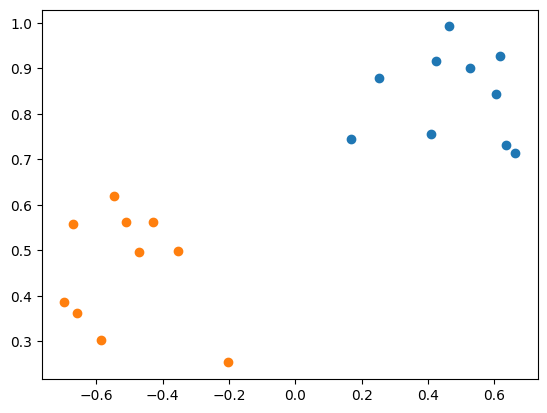

In [ ]:
import matplotlib.pyplot as plt
latent_samples = latent_samples.detach().cpu()
plt.scatter(latent_samples[2::32,5],latent_samples[2::32,6])
plt.scatter(latent_samples[10::32,5],latent_samples[10::32,6])

In [ ]:
latent_samples = []
for _ in range(10):
    latent_samples.append(vae.reparameterize(latent_mean, latent_logvar))
latent_samples = torch.cat(latent_samples, dim=0) # sample* B, 3


In [22]:
vae.eval()
a = ds[0]
tokenizer.detokenize(tokenizer.idx_to_token_seq(a['indices'].cpu().numpy())).to_midi(output_dir/'interpolate_a.mid')

b = ds[4]
tokenizer.detokenize(tokenizer.idx_to_token_seq(b['indices'].cpu().numpy())).to_midi(output_dir/'interpolate_b.mid')

z_a, _ = vae.encoder(a['indices'].unsqueeze(0).to(device), a['pos'].unsqueeze(0).to(device))
z_b, _ = vae.encoder(b['indices'].unsqueeze(0).to(device), b['pos'].unsqueeze(0).to(device))

prs: list[Pianoroll] = []
for lerp in torch.linspace(0,1,10):
    z = z_a*lerp + z_b*(1-lerp)
    prs.append(inference(z, length=120))

pr_all = prs[0]
for i, pr in enumerate(prs[1:]):
    pr_all = pr_all | pr

pr_all.to_midi(output_dir/'interpolated.mid')



100%|██████████| 119/119 [00:00<00:00, 143.36it/s]


120  tokens : [{'type': 'start'}, {'value': 20, 'type': 'pitch'}, {'value': 17, 'type': 'velocity'}, {'value': 39, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'value': 41, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'value': 51, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'value': 53, 'type': 'pitch'}]


100%|██████████| 119/119 [00:00<00:00, 154.54it/s]


120  tokens : [{'type': 'start'}, {'value': 7, 'type': 'pitch'}, {'value': 17, 'type': 'velocity'}, {'value': 39, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'value': 43, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'value': 46, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'value': 51, 'type': 'pitch'}]


100%|██████████| 119/119 [00:00<00:00, 162.88it/s]


120  tokens : [{'type': 'start'}, {'value': 15, 'type': 'pitch'}, {'value': 17, 'type': 'velocity'}, {'value': 39, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'value': 46, 'type': 'pitch'}, {'value': 15, 'type': 'velocity'}, {'value': 51, 'type': 'pitch'}, {'value': 24, 'type': 'velocity'}, {'type': 'next_frame'}]


100%|██████████| 119/119 [00:00<00:00, 145.49it/s]


120  tokens : [{'type': 'start'}, {'value': 17, 'type': 'pitch'}, {'value': 17, 'type': 'velocity'}, {'value': 29, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'value': 39, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'value': 51, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'type': 'next_frame'}]


100%|██████████| 119/119 [00:00<00:00, 168.50it/s]


120  tokens : [{'type': 'start'}, {'value': 20, 'type': 'pitch'}, {'value': 16, 'type': 'velocity'}, {'value': 41, 'type': 'pitch'}, {'value': 17, 'type': 'velocity'}, {'value': 44, 'type': 'pitch'}, {'value': 15, 'type': 'velocity'}, {'value': 51, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'value': 53, 'type': 'pitch'}]


100%|██████████| 119/119 [00:00<00:00, 170.60it/s]


120  tokens : [{'type': 'start'}, {'value': 20, 'type': 'pitch'}, {'value': 15, 'type': 'velocity'}, {'value': 39, 'type': 'pitch'}, {'value': 17, 'type': 'velocity'}, {'value': 43, 'type': 'pitch'}, {'value': 16, 'type': 'velocity'}, {'value': 46, 'type': 'pitch'}, {'value': 18, 'type': 'velocity'}, {'value': 51, 'type': 'pitch'}]


100%|██████████| 119/119 [00:00<00:00, 164.78it/s]


120  tokens : [{'type': 'start'}, {'value': 15, 'type': 'pitch'}, {'value': 9, 'type': 'velocity'}, {'value': 27, 'type': 'pitch'}, {'value': 11, 'type': 'velocity'}, {'value': 43, 'type': 'pitch'}, {'value': 14, 'type': 'velocity'}, {'value': 51, 'type': 'pitch'}, {'value': 15, 'type': 'velocity'}, {'type': 'next_frame'}]


100%|██████████| 119/119 [00:00<00:00, 138.84it/s]


120  tokens : [{'type': 'start'}, {'value': 17, 'type': 'pitch'}, {'value': 11, 'type': 'velocity'}, {'value': 29, 'type': 'pitch'}, {'value': 12, 'type': 'velocity'}, {'value': 39, 'type': 'pitch'}, {'value': 10, 'type': 'velocity'}, {'value': 51, 'type': 'pitch'}, {'value': 17, 'type': 'velocity'}, {'type': 'next_frame'}]


100%|██████████| 119/119 [00:00<00:00, 138.20it/s]


120  tokens : [{'type': 'start'}, {'value': 17, 'type': 'pitch'}, {'value': 12, 'type': 'velocity'}, {'value': 29, 'type': 'pitch'}, {'value': 11, 'type': 'velocity'}, {'value': 41, 'type': 'pitch'}, {'value': 10, 'type': 'velocity'}, {'value': 51, 'type': 'pitch'}, {'value': 17, 'type': 'velocity'}, {'type': 'next_frame'}]


100%|██████████| 119/119 [00:00<00:00, 155.57it/s]

120  tokens : [{'type': 'start'}, {'value': 17, 'type': 'pitch'}, {'value': 9, 'type': 'velocity'}, {'value': 29, 'type': 'pitch'}, {'value': 9, 'type': 'velocity'}, {'value': 45, 'type': 'pitch'}, {'value': 13, 'type': 'velocity'}, {'value': 51, 'type': 'pitch'}, {'value': 11, 'type': 'velocity'}, {'value': 53, 'type': 'pitch'}]


ticks per beat: 480
max tick: 0
tempo changes: 1
time sig: 0
key sig: 0
markers: 0
lyrics: False
instruments: 1

In [ ]:
pr = prs[0]
for i, pr in enumerate(prs[1:]):
    pr = pr | prs[i]
    print(pr, prs[i], pr | prs[i])


PianoRoll Bar 000 - 002 of  PianoRoll Bar 000 - 001 of  PianoRoll Bar 000 - 003 of 
PianoRoll Bar 000 - 002 of  PianoRoll Bar 000 - 001 of  PianoRoll Bar 000 - 003 of 
PianoRoll Bar 000 - 002 of  PianoRoll Bar 000 - 001 of  PianoRoll Bar 000 - 003 of 
PianoRoll Bar 000 - 002 of  PianoRoll Bar 000 - 001 of  PianoRoll Bar 000 - 003 of 
PianoRoll Bar 000 - 002 of  PianoRoll Bar 000 - 001 of  PianoRoll Bar 000 - 003 of 
PianoRoll Bar 000 - 002 of  PianoRoll Bar 000 - 001 of  PianoRoll Bar 000 - 003 of 
PianoRoll Bar 000 - 002 of  PianoRoll Bar 000 - 001 of  PianoRoll Bar 000 - 003 of 
PianoRoll Bar 000 - 002 of  PianoRoll Bar 000 - 001 of  PianoRoll Bar 000 - 003 of 
PianoRoll Bar 000 - 002 of  PianoRoll Bar 000 - 001 of  PianoRoll Bar 000 - 003 of 


In [ ]:
latent_samples[::32,:5]

torch.Size([320, 256])

100%|██████████| 119/119 [00:00<00:00, 142.70it/s]

result: [{'type': 'start'}, {'value': 8, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'value': 20, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


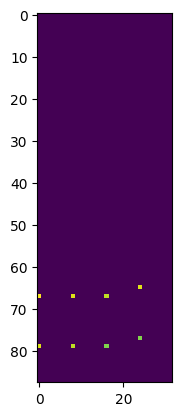

In [ ]:
import matplotlib.pyplot as plt
tokens, pr = inference(torch.randn(1, 256).to(device), output_dir/f'{epoch}_{i}_random.mid', length=120)
plt.imshow(pr.to_tensor(start_time=0,end_time=32,padding=True).transpose(0,1).flip(0)/127)


In [ ]:
mean = torch.zeros(2,2000)
var = torch.ones(2,2000)
mean[0,0] += 2
get_confidence(mean, var)

tensor(0.8808)

In [ ]:
get_confidence(latent_mean*500, latent_logvar.exp())

tensor(0.5097, device='cuda:0', grad_fn=<DivBackward0>)

In [10]:
fpr_ds = PianoRollDataset(r'W:\music\music-data-analysis\data', max_duration=32*150)

Loaded 2368 samples from 2570 songs


Full song

In [63]:
import matplotlib.pyplot as plt
vae.eval()
pr = fpr_ds.get_piano_roll(9)
zs: list[torch.Tensor] = []
for i in range(pr.duration//32):
    bar = pr.slice(i*32, (i+1)*32)
    idx, pos = tokenizer.pr_to_idx(bar, return_pos=True)
    idx = torch.tensor(idx).to(device).unsqueeze(0)
    pos = torch.tensor(pos).to(device).unsqueeze(0)
    z, _ = vae.encoder(idx, pos)
    z = z[0]
    zs.append(z.detach())

#writer.add_embedding(tag='fullsong',mat=torch.cat(zs, dim=0), metadata=[i for i in range(len(zs))],global_step=step)
pr.to_midi(output_dir/'fullsong.mid')

mean = sum(zs) / len(zs)
# similarity matrix
dist = torch.zeros(len(zs), len(zs))
for i in tqdm(range(len(zs))):
    for j in range(i, len(zs)):
        dist[i,j] = dist[j,i] = (zs[i]-zs[j]).norm()
        # a = zs[i]-mean
        # b = zs[j]-mean
        # dist[i,j] = dist[j,i] = torch.dot(a,b)/(a.norm()*b.norm())



C:\Users\User\AppData\Local\Temp\ipykernel_49072\1719682150.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos = torch.tensor(pos).to(device).unsqueeze(0)
100%|██████████| 72/72 [00:00<00:00, 295.02it/s]


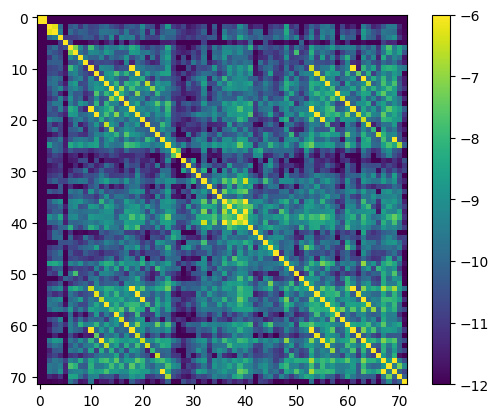

In [64]:
a = -dist

a = a[:90,:90]
plt.imshow(a, vmin=-12, vmax=-6)
plt.colorbar()

# normalize per row
# for i in range(len(zs)):
#     a[i] = a[i] / a[i][0:max(0,i-1)].mean()
# a = a[:80,:80]
# plt.imshow(-a, vmin=-1.0, vmax=-0.5)
# plt.colorbar()

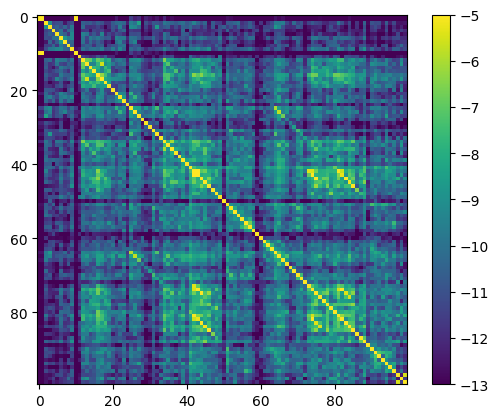

In [60]:
a = -dist
a = a[:100,:100]
plt.imshow(a,vmax=-5, vmin=-13)
plt.colorbar()

In [29]:
dist[15,16]

tensor(8.3803)

In [68]:
adj_dist = []
for i in range(len(zs)):
    sum_dist = 0
    for p in range(1,8):
        j = i + p
        if j < len(zs):
            sum_dist += dist[i,j]*(0.9**p)

    adj_dist.append(sum_dist)
    
adj_dist = torch.tensor(adj_dist)
plt.plot(adj_dist[:80]-adj_dist[1:81])

RuntimeError: The size of tensor a (72) must match the size of tensor b (71) at non-singleton dimension 0

100%|██████████| 72/72 [00:00<00:00, 637.15it/s]


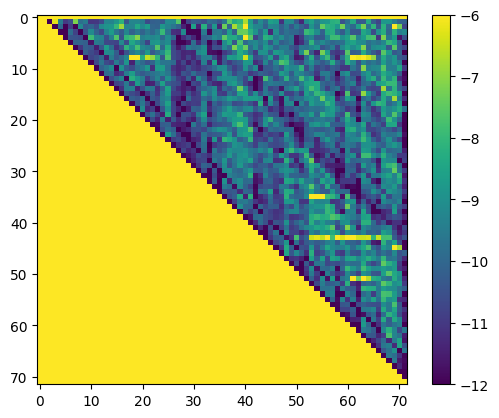

In [67]:
lag = torch.zeros(len(zs), len(zs))
for t in tqdm(range(len(zs))):
    for l in range(0, t):
        lag[l,t] = (zs[t]-zs[t-l]).norm()

a = -lag
plt.imshow(a, vmin=-12, vmax=-6)
plt.colorbar()

In [56]:
lag

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000, 13.5998,  ...,  8.6672,  5.7728, 12.5280],
        [ 0.0000,  0.0000,  0.0000,  ...,  9.9159,  9.3714, 10.4575],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000, 15.0411, 11.2542],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000, 12.9479],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])

In [23]:
def get_sim(a:Pianoroll, b:Pianoroll):
    pitch_shift_search = [0,-12,12]
    num_overlaps_list = []
    for pitch_shift in pitch_shift_search:
        num_overlaps = get_num_overlaps(a, b, pitch_shift)
        num_overlaps_list.append(num_overlaps)
    return max(num_overlaps_list)

def get_num_overlaps(a:Pianoroll, b:Pianoroll, pitch_shift:int):
    num_overlaps = 0
    i = 0
    j = 0
    i_max = len(a.notes)
    j_max = len(b.notes)
    seen_pitch = [0]*128
    denom = 0
    while i < i_max and j < j_max:
        note_a = a.notes[i]
        note_b = b.notes[j]
        
        if note_a.onset < note_b.onset:
            i += 1
        elif note_a.onset > note_b.onset:
            j += 1
        else:
            if note_a.pitch == note_b.pitch + pitch_shift and seen_pitch[note_a.pitch] < 2:
                num_overlaps += 1
            i += 1
            j += 1
        
        if seen_pitch[note_a.pitch] < 2:
            denom += 1
        if seen_pitch[note_b.pitch] < 2:
            denom += 1
        seen_pitch[note_a.pitch] += 1
        seen_pitch[note_b.pitch] += 1
    if denom == 0:
        return 0
    return num_overlaps / denom * 2


100%|██████████| 148/148 [00:00<00:00, 439.96it/s]


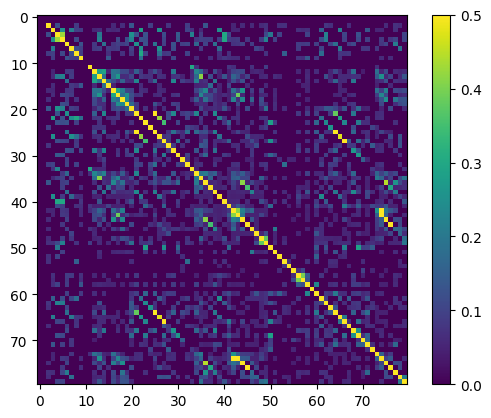

In [24]:
sim_mat = torch.zeros(len(zs), len(zs))
pr_bars = []

for i in tqdm(range(len(zs))):
    pr_bars.append(pr.slice(i*32, (i+1)*32))
for i in tqdm(range(len(zs))):
    for j in range(i, len(zs)):
        sim_mat[i,j] = sim_mat[j,i] = get_sim(pr_bars[i], pr_bars[j])

plt.imshow(sim_mat[:80,:80], vmin=0, vmax=0.5)
plt.colorbar()


In [60]:
def get_similar_bars(dist_map: torch.Tensor, query: int, k:int=10):
    idx = torch.argsort(dist_map[query])[1:k+1]
    return idx

def get_similar_bars_prev(dist_map: torch.Tensor, query: int, k:int=10):
    idx = torch.argsort(dist_map[query][:query])[:k]
    return idx

get_similar_bars_prev(dist, 37)


tensor([15, 26, 36, 34, 19, 12, 22, 14, 35, 16])

def get_similar_bars(

In [ ]:
pr = fpr_ds.get_piano_roll(6)
zs1 = []
for i in range(pr.duration//32):
    bar = pr.slice(i*32, (i+1)*32)
    idx, pos = tokenizer.pr_to_idx(bar, return_pos=True)
    idx = torch.tensor(idx).to(device).unsqueeze(0)
    pos = torch.tensor(pos).to(device).unsqueeze(0)
    z, _ = vae.encoder(idx, pos)
    zs1.append(z)

pr = fpr_ds.get_piano_roll(7)
zs2 = []
for i in range(pr.duration//32):
    bar = pr.slice(i*32, (i+1)*32)
    idx, pos = tokenizer.pr_to_idx(bar, return_pos=True)
    idx = torch.tensor(idx).to(device).unsqueeze(0)
    pos = torch.tensor(pos).to(device).unsqueeze(0)
    z, _ = vae.encoder(idx, pos)
    zs2.append(z)

writer.add_embedding(tag='fullsong',mat=torch.cat(zs1 + zs2, dim=0), metadata=[0 for _ in range(len(zs1))] + [1 for _ in range(len(zs2))],global_step=1)

C:\Users\User\AppData\Local\Temp\ipykernel_27872\3117660653.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos = torch.tensor(pos).to(device).unsqueeze(0)
C:\Users\User\AppData\Local\Temp\ipykernel_27872\3117660653.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos = torch.tensor(pos).to(device).unsqueeze(0)


In [ ]:
class SongModel(nn.Module):
    def __init__(self, latent_dim:int, feature_dim:int, n_category:int=8):
        super().__init__()
        self.pe = SinusoidalPositionalEncoding(feature_dim//2, 32)
        self.stage1 = nn.TransformerEncoder(nn.TransformerEncoderLayer(feature_dim, 8, 1024, batch_first=True), 4)
        self.stage2 = nn.Sequential(
            nn.Linear(feature_dim, feature_dim),
            nn.LeakyReLU(),
            nn.Linear(feature_dim, latent_dim)



ticks per beat: 480
max tick: 0
tempo changes: 1
time sig: 0
key sig: 0
markers: 0
lyrics: False
instruments: 1